In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import os
import numpy as np
import tensorflow as tf
import cv2
import glob
import natsort
import matplotlib.pyplot as plt

In [9]:
import os
print(os.listdir("/kaggle/input"))

['flood-dataset']


In [10]:
dataset_path = "/kaggle/input/flood-dataset"
print(os.listdir(dataset_path)) 

['flood detection dataset']


In [11]:
dataset_path = "/kaggle/input/flood-dataset/flood detection dataset"
image_dir =  f"{dataset_path}/Image"
mask_dir = f"{dataset_path}/Mask"

image_paths = natsort.natsorted(glob.glob(os.path.join(image_dir, "*.jpg")))
mask_paths = natsort.natsorted(glob.glob(os.path.join(mask_dir, "*.png")))

assert len(image_paths) == len(mask_paths)

In [12]:
def load_and_preprocess(img_path, mask_path, img_size=(256, 256)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype("float32") / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    mask = np.where(mask > 128, 1, 0).astype("float32")

    return img, mask

images, masks = zip(*[load_and_preprocess(img, mask) for img, mask in zip(image_paths, mask_paths)])

images = np.array(images)
masks = np.array(masks)

Text(0.5, 1.0, 'Masked image')

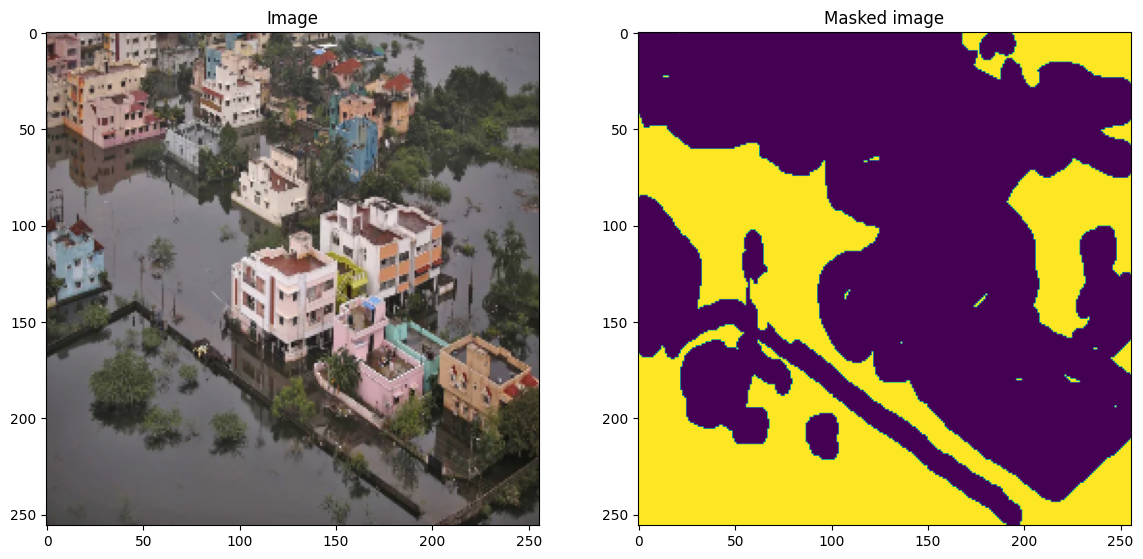

In [13]:
import random
random_image_id = random.randint(0, len(images))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(images[random_image_id])
plt.title("Image")
plt.subplot(122)
plt.imshow(masks[random_image_id])
plt.title("Masked image")

In [14]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks, test_size=0.4, random_state=42)

print(f" Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

 Train: 231, Val: 34, Test: 24


In [15]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [17]:
def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):

    inputs = Input(input_shape)
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    b = residual_block(s3, 512, strides=2)

    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs, outputs, name="RESUNET")

    return model

In [39]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

mIoU = MeanIoU(num_classes=2)
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

def mean_iou(y_true, y_pred):
    return mIoU(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [40]:
input_shape = (256, 256, 3)
model = build_resunet(input_shape)

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
              loss=combined_loss,  
              metrics=["accuracy",dice_coefficient, f1_score, mean_iou, precision, recall])

In [57]:
model.summary()

Model: "RESUNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 256, 256, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 256, 256, 64)   │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 256, 256, 64)   │              0 │ conv2d_23[0][0],       │
│                           │                        │                │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 256, 256, 64)   │            256 │ add_7[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ activation_14[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 128, 128, 128)  │            512 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_15[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 128, 128, 128)  │          8,320 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 128, 128, 128)  │              0 │ conv2d_26[0][0],       │
│                           │                        │                │ conv2d_27[0][0]        │
├──────────────────────

 Total params: 8,227,393 (31.39 MB)

 Trainable params: 8,220,993 (31.36 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [58]:
model_history=model.fit(train_images, train_masks, validation_data=(val_images, val_masks), batch_size=8, epochs=100)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 971ms/step - accuracy: 0.8586 - dice_coefficient: 0.7907 - f1_score: 0.8342 - loss: 0.2975 - mean_iou: 0.2880 - precision_2: 0.8391 - recall_2: 0.8194 - val_accuracy: 0.3793 - val_dice_coefficient: 0.5659 - val_f1_score: 0.5354 - val_loss: 1.6217 - val_mean_iou: 0.2963 - val_precision_2: 0.3761 - val_recall_2: 0.9998
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 548ms/step - accuracy: 0.8645 - dice_coefficient: 0.7881 - f1_score: 0.8277 - loss: 0.2868 - mean_iou: 0.2962 - precision_2: 0.8418 - recall_2: 0.8225 - val_accuracy: 0.4175 - val_dice_coefficient: 0.5928 - val_f1_score: 0.5579 - val_loss: 1.1241 - val_mean_iou: 0.2740 - val_precision_2: 0.3910 - val_recall_2: 0.9982
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 555ms/step - accuracy: 0.8710 - dice_coefficient: 0.8022 - f1_score: 0.8405 - loss: 0.2603 - mean_iou: 0.2591 - precision_2: 0.8503 - recall_2: 0.8409 - val_accuracy: 0.5926 - val_dice_coefficient: 0.6567 - val_f1_score: 0.6541 - val

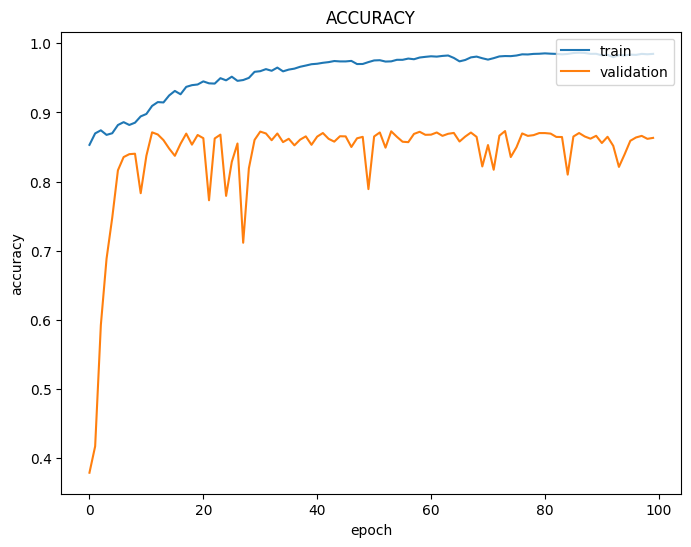

In [59]:
fig,ax11=plt.subplots(figsize=(8,6))
ax11.plot(model_history.history['accuracy'])
ax11.plot(model_history.history['val_accuracy'])
ax11.title.set_text('ACCURACY')
ax11.set_ylabel('accuracy')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper right')

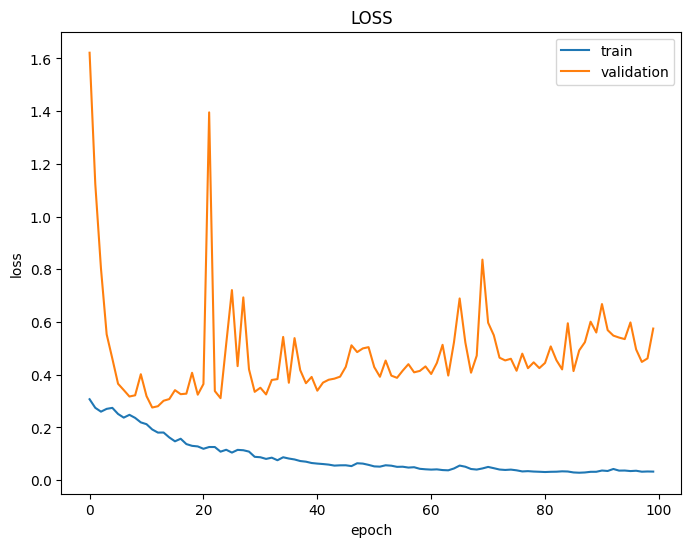

In [60]:
fig,ax12 = plt.subplots(figsize=(8,6))
ax12.plot(model_history.history['loss'])
ax12.plot(model_history.history['val_loss'])
ax12.title.set_text('LOSS')
ax12.set_ylabel('loss')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper right')

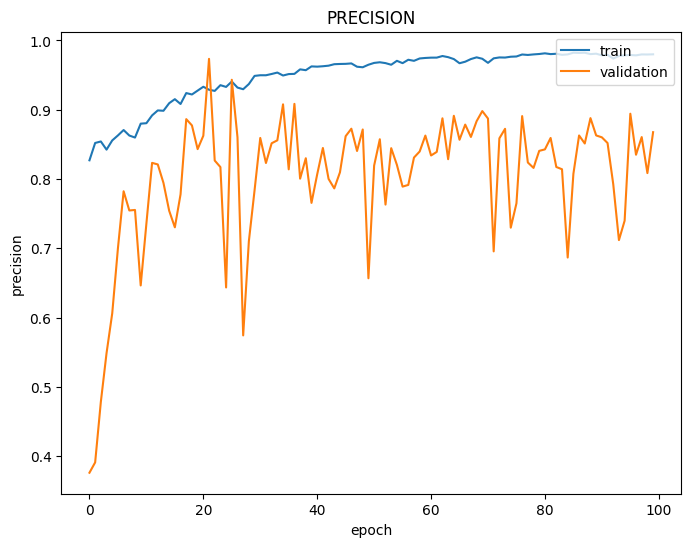

In [61]:
fig,ax13=plt.subplots(figsize=(8,6))
ax13.plot(model_history.history['precision_2'])
ax13.plot(model_history.history['val_precision_2'])
ax13.title.set_text('PRECISION')
ax13.set_ylabel('precision')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper right')

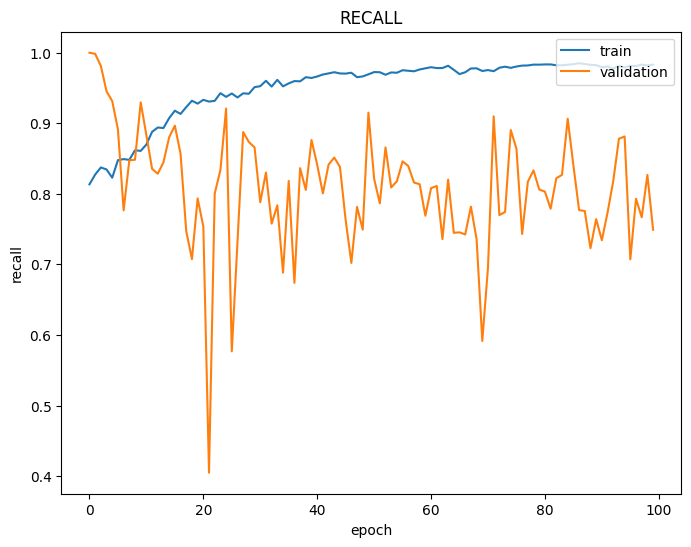

In [62]:
fig,ax14=plt.subplots(figsize=(8,6))
ax14.plot(model_history.history['recall_2'])
ax14.plot(model_history.history['val_recall_2'])
ax14.title.set_text('RECALL')
ax14.set_ylabel('recall')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper right')

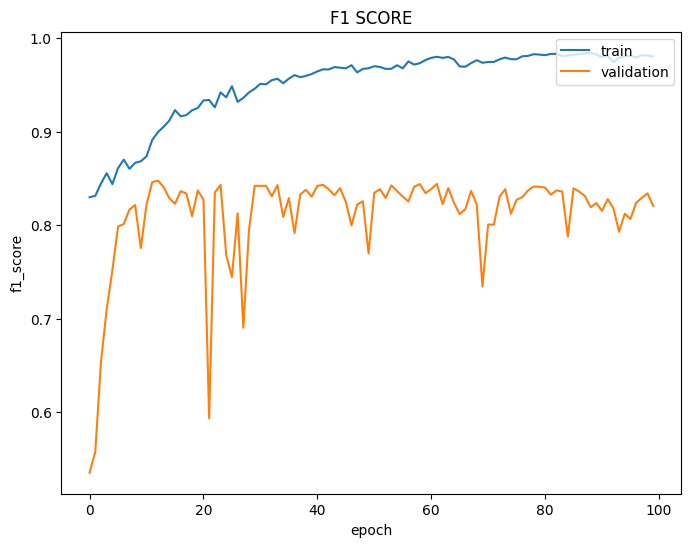

In [63]:
fig,ax15=plt.subplots(figsize=(8,6))
ax15.plot(model_history.history['f1_score'])
ax15.plot(model_history.history['val_f1_score'])
ax15.title.set_text('F1 SCORE')
ax15.set_ylabel('f1_score')
ax15.set_xlabel('epoch')
ax15.legend(['train', 'validation'], loc='upper right')

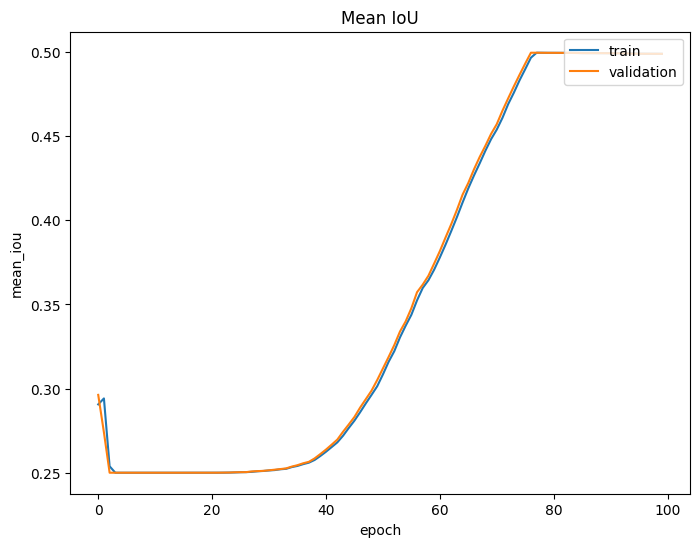

In [64]:
fig,ax16=plt.subplots(figsize=(8,6))
ax16.plot(model_history.history['mean_iou'])
ax16.plot(model_history.history['val_mean_iou'])
ax16.title.set_text('Mean IoU')
ax16.set_ylabel('mean_iou')
ax16.set_xlabel('epoch')
ax16.legend(['train', 'validation'], loc='upper right')

In [65]:
pred_masks = model.predict(test_images)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


In [66]:
loss,dice_coefficient, accuracy, f1_score, precision, recall,mean_iou = model.evaluate(test_images, test_masks, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"dice coefficient: {dice_coefficient:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test MeanIoU: {mean_iou:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9190 - dice_coefficient: 0.8929 - f1_score: 0.8972 - loss: 0.2909 - mean_iou: 0.4990 - precision_2: 0.9165 - recall_2: 0.8788
Test Loss: 0.2909
dice coefficient: 0.9190
Test Accuracy: 0.8929
Test F1 Score: 0.8972
Test Precision: 0.4990
Test Recall: 0.9165
Test MeanIoU: 0.8788


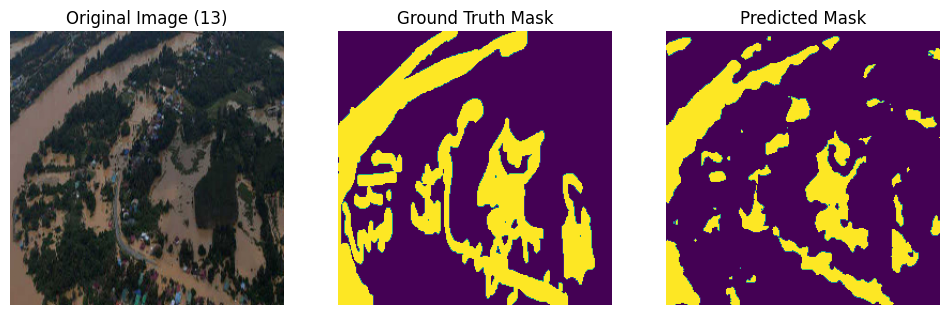

In [68]:
def visualize_random_prediction(test_images, test_masks, pred_masks):
    idx = random.randint(0, len(test_images) - 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images[idx])
    plt.title(f"Original Image ({idx})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[idx].squeeze())
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[idx].squeeze())
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

visualize_random_prediction(test_images, test_masks, pred_masks)